# Simple MLP

---

---

### Overview

This notebook trains a simple multi-layer perceptron network to predict `y` as an unconstrained function of `x1`, `x2`, `x3`, and `x4`.  It uses an embedding layer for `x3` and linear layers with ReLU activation for the remainder.

Its purpose is to illustrate that, unless constrained, `x1`'s relationship to `y` will be non-monotonic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

---

### Define network and model

[skorch](https://github.com/skorch-dev/skorch) takes PyTorch Module's as input.  We could just as easily train this using the standard PyTorch API, or an alternative like [PyTorch Lightning](https://www.pytorchlightning.ai/).  However, given that skorch is used extensively throughout this repository it makes sense to start here.

Notice:
- We create a realtively small embedding layer for the 50 unique values of `x3`.
- `X_numeric` and `X_categorical` are supplied as separate inputs to `.forward()` and concatenated after `X_categorical` is embedded.

In [3]:
class SimpleMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(3 + 16, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, X_numeric, X_categorical1):
        X = torch.cat([X_numeric, self.emb1(X_categorical1).squeeze()], 1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.fc4(X)

skorch's `NeuralNetRegressor()` takes the network we've defined as input, and has custom arguments for common input parameters like number of epochs (`max_epochs`) and learning rate (`lr`).

In [4]:
model = NeuralNetRegressor(SimpleMLP,
                           max_epochs=150,
                           lr=0.01,
                           optimizer=torch.optim.Adam,
                           iterator_train__shuffle=True)

### Train and examine

skorch allows us to simply use `.fit()` and pass in numpy arrays to train our network.

Notice:
- The typical `X` argument in sklearn is now a `dict` with keys that correspond to the input arguments for our network's `.forward()` function.
- `y` is required to be a 2-dimensional array (not 1-d).

In [5]:
model.fit({'X_numeric': df[['x1', 'x2', 'x4']].values,
           'X_categorical1': df[['x3']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3415        0.3541  0.5720
      2        0.2794        0.2965  0.0628
      3        0.2098        0.1704  0.0579
      4        0.1202        0.2444  0.0622
      5        0.1057        0.1372  0.0673
      6        0.0739        0.1504  0.0623
      7        0.0535        0.1351  0.0611
      8        0.0409        0.1329  0.0594
      9        0.0393        0.1425  0.0612
     10        0.0340        0.1317  0.0587
     11        0.0313        0.1274  0.0630
     12        0.0292        0.1547  0.0651
     13        0.0324        0.1212  0.0554
     14        0.0275        0.1517  0.0551
     15        0.0285        0.1353  0.0568
     16        0.0269        0.1328  0.0563
     17        0.0233        0.1325  0.0540
     18        0.0213        0.1453  0.0622
     19        0.0200        0.1196  0.0625
     20        0.0193        0.1286  0.0570
     21        0.0195        0.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleMLP(
    (emb1): Embedding(50, 16)
    (fc1): Linear(in_features=19, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=1, bias=True)
  ),
)

Next, we'll create a partial dependence plot for `x1`.  This consists of sequentially setting `x1` to the same value for all observations, across a full spectrum of values, and then summarizing the predictions.

Notice:
- We can use `.predict()` on our model, passing in a `dict` with keys that correspond to arguments in our network's `.forward()` function and values that are numpy arrays.

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_numeric': dfc[['x1', 'x2', 'x4']].values,
                       'X_categorical1': dfc[['x3']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

When plotting the values, we can clearly see the shape the cubic shape that we expect, with respect to `x1`, and see clear evidence of non-monotonicity (Given that we defined the functional form to be non-monotonic, that makes sense, but there often cases where data noise might create subtle non-monotonicity that is undesirable in a practical scenario).

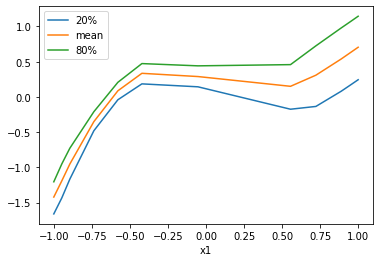

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

A montonically constrained extension of this model can be found in [mixed_monotonic](./mixed_monotonic.ipynb).